# Face Detection Using Viola-Jones Algorithm 

In [1550]:
import numpy as np
from PIL import Image, ImageOps
import os
#--------------------------------
import requests # for streaming data online
# --------------------------
import shutil # allows you to do high-level operations on a file,
# such as copy, create, and remote operations 
#  -------------------------- 
import hashlib # provides a variety of hash 
# functions, including md5 , sha1 , and sha256 
# -------------------------
import tarfile #  portable utility for reading and writing tar archives
# ----------------------------------
import glob   # a function that's used to search for files that match
# a specific file pattern or name
# ----------------------------------
import random
# --------------------
from typing import *  
#-----------------------
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette('muted')
#-------------------------------------
from sklearn.metrics import *


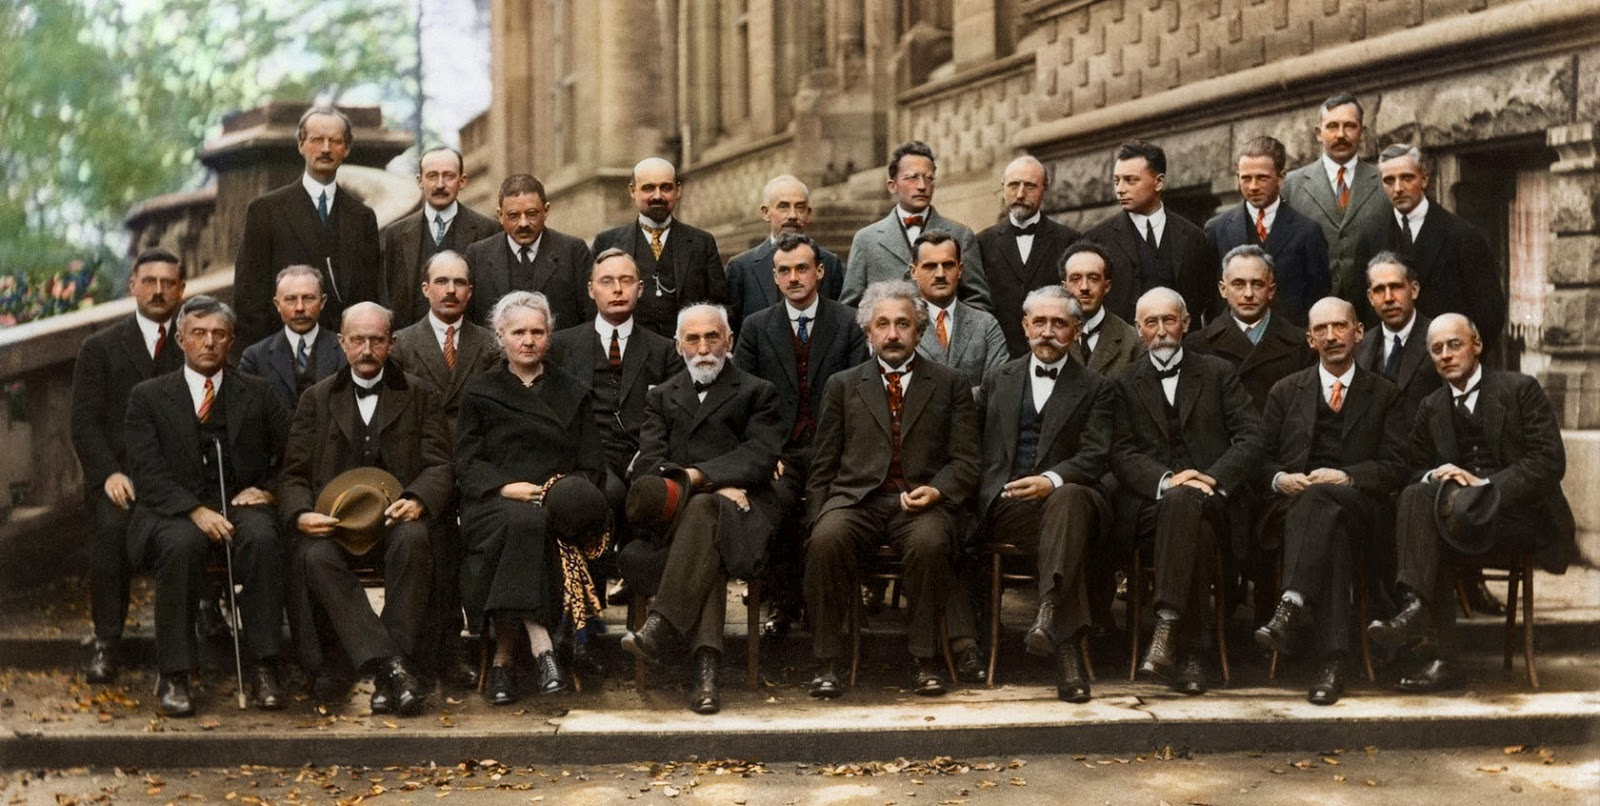

In [1551]:
original_image = Image.open("images/solvay-conference.jpg")
original_image

In [1552]:
original_image.size # very large image. 

(1600, 806)

I have found this point in the paper of Viola and Jones 
> On
a 700 Mhz Pentium III processor, the face detector can process a 384 by 288 pixel image in about **.067** seconds (using a starting scale of 1.25 and a step size of 1.5 described
below)

In [1553]:
def resize_image_object(img, target_size):
    thumbnail_image = img.copy()
    thumbnail_image.thumbnail(target_size, Image.LANCZOS) # anti-alising-resize
    return thumbnail_image


(384, 193)


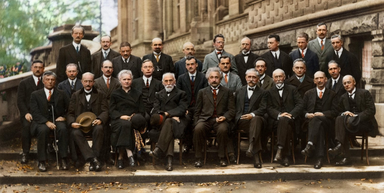

In [1554]:
thumbnail_image = resize_image_object(original_image, (384, 288))
print(thumbnail_image.size)
thumbnail_image

In [1555]:
def to_float_array(img): 
    return np.array(img).astype(np.float32) / 255.0 # float division 

def to_image(arr):
    return Image.fromarray(np.uint8(arr * 255.0))

In [1556]:
original = to_float_array(thumbnail_image)
original.shape

(193, 384, 3)

## Grayscale Conversion 

It turns out that grayscale conversion is important in face recognition, this has been discussed in Kanan and Cottrell 2012 Paper [Color-to-Grayscale: Does the Method Matter in Image Recognition?](http://tdlc.ucsd.edu/SV2013/Kanan_Cottrell_PLOS_Color_2012.pdf) ([DOI](https://doi.org/10.1371/journal.pone.0029740)). 

This conversion is very simple, but not the optimal. 
$$
\mathcal{G}_{Intensity} \leftarrow \frac{1}{3}\left(R + G + B\right),
$$


This conversion considers the eye sensitivity to diffferent colors, but indeed it's not as powerful as it is in face detection 

$$
\mathcal{G}_{\text{Intensity}} \leftarrow (R \times 0.2989 + G \times 0.5870 + B \times 0.1140),
$$


Gleam converions is the optimal, it uses gamma corrected channels 
([Gamma Correction](https://en.wikipedia.org/wiki/Gamma_correction))


$$
\mathcal{G}_{Gleam} \leftarrow \frac{1}{3}\left(R' + G' + B'\right)
$$
Where 

$$
t' = \Gamma(t) = t^{1/coeff}.
$$

where \
\
$coeff = 1, 1.5, 2, 2.2, ...$

In [1557]:
def gamma(channel, coeff = 1):
    return channel**(1./coeff)

def gleam_converion(img):
    return np.sum(gamma(img), axis=2) / img.shape[2] # divide by 3 

0.0 0.9712418


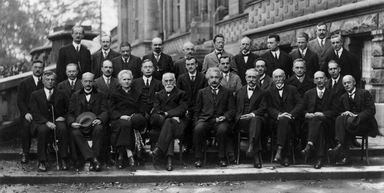

In [1558]:
grayscale_image = gleam_converion(original)
print(grayscale_image.min(), grayscale_image.max())
to_image(grayscale_image)

## Features (Haar-like Features) 

Viola and Jones have defined four base Haar-like features; two two-rectangle features, one three-rectangle one and four-rectangle features. They can be understood as follows:

$$
\begin{align}
\mathcal{F}_{2,h} &= \begin{bmatrix}
    1 & -1
    \end{bmatrix} \\
\mathcal{F}_{2,v} &= \begin{bmatrix}
    -1 \\ 1
    \end{bmatrix} \\
\mathcal{F}_{3,h} &= \begin{bmatrix}
    -1 & 1 & -1
    \end{bmatrix} \\
\mathcal{F}_{4} &= \begin{bmatrix}
    1 & -1 \\
    -1 & 1
\end{bmatrix} 
\end{align}.
$$

![Example Image](images\haar_like_featrures.png)

There is another Haar-like feature proposed, which is: 


$$
\begin{align}
\mathcal{F}_{3,v} &= \begin{bmatrix}
    -1 \\ 1 \\ -1
    \end{bmatrix}
\end{align}.
$$


The technique relies upon placing a subframe (window) of $24 \times 24$ pixels within an image, and subsequently placing these 5 rectangular features inside it in every position with every size possible.

In [1559]:
WINDOW_SIZE = 15 # the tuning factor, which wil help us detect faces 
# at different scales 

## Integral Image

An integral image $\mathcal{I}^\ast$ contains the sum (the _discrete_ integral) of all values top and left of a specific point, i.e. each point $i, j$ is determined by the sum

$$
\mathcal{I}^{\ast}_{i, j} = \sum_{x=0}^{i} \sum_{y=0}^{j} \mathcal{I}_{i, j}
$$

of intensity values of the source image $\mathcal{I}$. 


In [1560]:
sub_image = np.array([
    [5, 2, 3, 4, 1], 
    [1, 5, 4, 2, 3],
    [2, 2, 1, 3, 4],
    [3, 5, 6, 4, 5],
    [4, 1, 3, 2, 6]])
row_column = np.cumsum(np.cumsum(sub_image, axis=0), axis=1) 
column_row = np.cumsum(np.cumsum(sub_image, axis=1), axis=0)
print(sub_image)
print(column_row)
print(row_column)

[[5 2 3 4 1]
 [1 5 4 2 3]
 [2 2 1 3 4]
 [3 5 6 4 5]
 [4 1 3 2 6]]
[[ 5  7 10 14 15]
 [ 6 13 20 26 30]
 [ 8 17 25 34 42]
 [11 25 39 52 65]
 [15 30 47 62 81]]
[[ 5  7 10 14 15]
 [ 6 13 20 26 30]
 [ 8 17 25 34 42]
 [11 25 39 52 65]
 [15 30 47 62 81]]


We can derive a formula to efficiently compute the integral image 
$$\mathcal{II}_{A} = \mathcal{II}_{B} + \mathcal{II}_{C} - \mathcal{II}_{C} + \mathcal{I}_{A}$$


![Example Image](images\integral_image.png)




For differentiation, we would adopt the same concept 

$$\mathcal{I}_{A} = \mathcal{II}_{A} - \mathcal{II}_{B} - \mathcal{II}_{C} + \mathcal{II}_{C}$$

In [1561]:
row_column_diff = np.diff(np.diff(row_column, axis=0), axis=1) 
row_column_diff # loss in the shape, so we need padding

array([[5, 4, 2, 3],
       [2, 1, 3, 4],
       [5, 6, 4, 5],
       [1, 3, 2, 6]])

In [1562]:
np.pad(column_row, (1, 1), 'constant', constant_values=(0, 0))
np.pad(column_row, (1, 1), 'constant', constant_values=(0, 0))[:-1,:-1]

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  5,  7, 10, 14, 15],
       [ 0,  6, 13, 20, 26, 30],
       [ 0,  8, 17, 25, 34, 42],
       [ 0, 11, 25, 39, 52, 65],
       [ 0, 15, 30, 47, 62, 81]])

In [1563]:
def integrate_image(img):
    """The padding compensates for the loss that might happen in differentiation"""
    integral = np.cumsum(np.cumsum(img, axis= 0), axis=1) # 2d integral
    return np.pad(integral, (1, 1), 'constant', constant_values=(0, 0))[:-1,:-1] 

In [1564]:
def diff_image(img):
    diff = np.diff(np.diff(img, axis= 0), axis=1) # 2d differentiation 
    return diff 

In [1565]:
print(grayscale_image.shape)
integral = integrate_image(grayscale_image)
print(integral.shape) 
integral # can not be represented 

(193, 384)
(194, 385)


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 4.9934641e-01, 1.0091504e+00, ..., 2.2570973e+02,
        2.2643391e+02, 2.2715025e+02],
       [0.0000000e+00, 9.5816994e-01, 1.9568628e+00, ..., 4.4978558e+02,
        4.5113068e+02, 4.5244308e+02],
       ...,
       [0.0000000e+00, 6.8525490e+01, 1.3662485e+02, ..., 2.2459264e+04,
        2.2551059e+04, 2.2641014e+04],
       [0.0000000e+00, 6.9169937e+01, 1.3795033e+02, ..., 2.2695439e+04,
        2.2788035e+04, 2.2878764e+04],
       [0.0000000e+00, 6.9873207e+01, 1.3933856e+02, ..., 2.2930902e+04,
        2.3024254e+04, 2.3115723e+04]], dtype=float32)

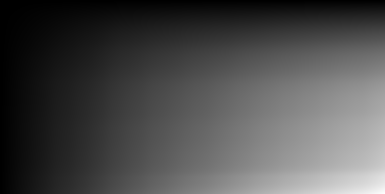

In [1566]:
to_image((integral - integral.min()) / (integral.max() - integral.min()))

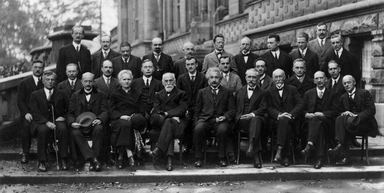

In [1567]:
to_image(diff_image(integral))

Why we might want to integrate the image ? 

**This help use to get the sum of a subframe in the image with least and constant computation time regardless of the size of the subframe**

In [1568]:
sub_image_integral = integrate_image(sub_image)
print(sub_image)
print(sub_image_integral)

[[5 2 3 4 1]
 [1 5 4 2 3]
 [2 2 1 3 4]
 [3 5 6 4 5]
 [4 1 3 2 6]]
[[ 0  0  0  0  0  0]
 [ 0  5  7 10 14 15]
 [ 0  6 13 20 26 30]
 [ 0  8 17 25 34 42]
 [ 0 11 25 39 52 65]
 [ 0 15 30 47 62 81]]


In [1569]:
# if i want to extract a sub window and sum it 
width, height = 3, 2
x, y = 1,1 # the top left corner of the widow  
print(sub_image[x:height+1, y:width+1])
np.sum(sub_image[x:height+1, y:width+1]) # access 3x2 = 6 & (5 adding operations) 

[[5 4 2]
 [2 1 3]]


17

In [1570]:
# what about getting the same result, but with less operations 
# we can achieve this using the integral image 
sub_image_integral[height + x , width + y] - sub_image_integral[x , width + y] \
- sub_image_integral[height + x , y] + sub_image_integral[x , y]  

17

same result with (4 accesses + 3 addition operations + 4 multiplications) = 11 operations

**The power of integral image appears with large windows**

In [1571]:
class Box:
    def __init__(self, x, y, width, height):
        self.coords_x = [x, x + width, x,          x + width]
        self.coords_y = [y, y,         y + height, y + height]
        self.coeffs   = [1, -1,        -1,         1]
    
    def __call__(self,integrate_image):
        return np.sum(integrate_image[self.coords_y, self.coords_x] * self.coeffs)

In [1572]:
box_object = Box(x, y, width, height)
box_object(sub_image_integral)

17

## Datasets Downloading

In order to train our classifier(s), we need some instances of the class to be found (the faces), and class to not be found (the backgorund or non-faces).

In [1573]:
dataset_path = 'dataset_face_detection'

if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

In [1574]:
# for downloading, we are going to us the following helper functions

def download_file(url, path):
    print('Downloading file ...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status() # check the request result
        with open(path, 'wb') as f: 
            r.raw.decode_content = True # the data is deconded
            shutil.copyfileobj(r.raw, f) # the data has been sent in chunks
    print('Download completed.')


def md5(path , chunk_size = 65536) :
    hash_md5 = hashlib.md5()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(chunk_size), b''): # iterate over the file in chunks
            hash_md5.update(chunk) 
    return hash_md5.hexdigest()


def untar(file_path, dest_path):
    print('Extracting file.')
    with tarfile.open(file_path, 'r:gz') as f:
        f.extractall(dest_path)
    print('Extraction completed.')


### Faces

For positive class ("face"), we're going to use the Yearbook Dataset from [A Century of Portraits:
A Visual Historical Record of American High School Yearbooks](https://people.eecs.berkeley.edu/~shiry/projects/yearbooks/yearbooks.html).

> Shiry Ginosar, Kate Rakelly, Sarah Sachs, Brian Yin, Crystal Lee, Alexei A. Efros **A Century of Portraits: A Visual Historical Record of American High School Yearbooks**, in IEEE Transactions on Computational Imaging, Vol. 3, No. 3, September 2017. [PDF](https://people.eecs.berkeley.edu/~shiry/publications/IEEE_yearbooks.pdf), [BibTeX](https://people.eecs.berkeley.edu/~shiry/projects/yearbooks/yearbooks.html#yearbooks_IEEE)

It contains 37,921 pictures of frontal-facing portraits of size $186 \times 171$ where we will assume the face to be in the center.

In [1575]:
faces_url = 'https://www.dropbox.com/s/ubjjoo0b2wz4vgz/faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz?dl=1'
faces_md5 = 'ab853c17ca6630c191457ff1fb16c1a4' # hash value of the archive 
# this hash value is computed from the binary data included

faces_archive = os.path.join(dataset_path, 'faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz')
faces_dir = os.path.join(dataset_path, 'faces_aligned_small_mirrored_co_aligned_cropped_cleaned')

if not os.path.exists(faces_archive) or md5(faces_archive) != faces_md5:
    download_file(faces_url, faces_archive)

In [1576]:
if not os.path.exists(faces_dir):
    untar(faces_archive, dataset_path)

In [1577]:
face_image_files = glob.glob(os.path.join(faces_dir, "**", "*.png"), recursive=True)


In [1578]:
print(f"The number of faces in the dateset: {len(face_image_files)}")

The number of faces in the dateset: 37921


In [1579]:
def open_face(path , resize = True):
    CROP_TOP = 50 # crop from top to remove hair, just facial features  
    img = Image.open(path)
    img = to_image(gleam_converion(to_float_array(img)[CROP_TOP:, :]))
    min_size = np.min(img.size)
    img = ImageOps.fit(img, (min_size, min_size), Image.Resampling.LANCZOS)
    if resize:
        img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.Resampling.LANCZOS)
    return img.convert('L')

In [1580]:
def merge_images(files , open_fun, resize = False):
    images = [open_fun(f, resize) for f in files]
    sizes = [img.size for img in images]
    collage_width = np.sum([size[0] for size in sizes])
    collage_height = np.max([size[1] for size in sizes])

    result = Image.new('L', (collage_width, collage_height))
    x_offset = 0
    for img, size in zip(images, sizes):
        result.paste(im=img, box=(x_offset, 0))
        x_offset += size[0]
    return result

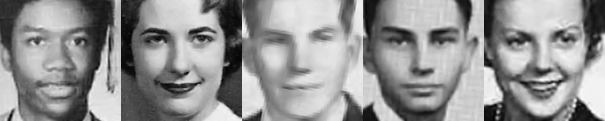

In [1581]:
random.seed(1000)
random_face_files = random.sample(face_image_files, 5)
merge_images(random_face_files, open_face)

In [1582]:
merge_images(random_face_files, open_face, True).size

(75, 15)

### Backgrounds

For the negative class ("not a face") we will make use of the [Stanford Backgrounds Dataset](http://dags.stanford.edu/projects/scenedataset.html) for scene understanding. It contains 715 images of various scenes, from which we will randomly crop regions to be used as background classes.

> S. Gould, R. Fulton, D. Koller. **Decomposing a Scene into Geometric and Semantically Consistent Regions.** Proceedings of International Conference on Computer Vision (ICCV), 2009. [pdf](http://www.stanford.edu/~sgould/papers/iccv09-sceneDecomposition.pdf)

The images are approximately of size $320 \times 240$ and do contain faces in camera-facing poses, but we'll ignore this for the time being. After all, the chance of randomly selecting a valid face that is exactly within the window region is pretty slim.

In [1583]:
backgrounds_url = 'http://dags.stanford.edu/data/iccv09Data.tar.gz'
backgrounds_md5 = 'f469cf0ab459d94990edcf756694f4d5'

backgrounds_archive = os.path.join(dataset_path, 'iccv09Data.tar.gz')
backgrounds_dir = os.path.join(dataset_path, 'iccv09Data')

if not os.path.exists(backgrounds_archive) or md5(backgrounds_archive) != backgrounds_md5:
    download_file(backgrounds_url, backgrounds_archive)

In [1584]:
if not os.path.exists(backgrounds_dir):
    untar(backgrounds_archive, dataset_path)

In [1585]:
background_image_files = glob.glob(os.path.join(backgrounds_dir, '**', '*.jpg'), recursive=True)
print(f"Number of background images: {len(background_image_files)}")

Number of background images: 715


In [1586]:
def random_crop(img):
    max_allowed_size = np.min(img.size) 
    size = random.randint(WINDOW_SIZE, max_allowed_size) # random new size 
    max_width = img.size[0] - size - 1
    max_height = img.size[1] - size - 1
    left = 0 if (max_width <= 1)  else random.randint(0, max_width)
    top  = 0 if (max_height <= 1) else random.randint(0, max_height)
    return img.crop((left,top,left+size,top+size))

def open_background(path , resize = True):
    img = Image.open(path)
    img = to_image(gleam_converion(to_float_array(img)))
    img = random_crop(img)
    if resize:
        img = img.resize((WINDOW_SIZE, WINDOW_SIZE), Image.Resampling.LANCZOS)
    return img.convert('L')

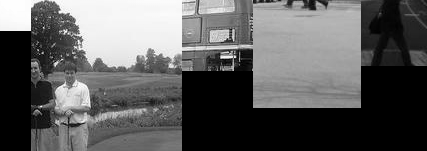

In [1587]:
random.seed(1000)
random_background_files = random.sample(background_image_files, 5)
merge_images(random_background_files, open_background)

In [1588]:
merge_images(random_background_files, open_background, True).size

(75, 15)

## Feature Extraction 

In this stage, we need to extract the features that we would train the classifer with. Towards that end, we would construct a class for each Haar-like feature and then parameterize it according to all possible values, yeilding about 160k instances per each image (face or non-face). the best features will be picked later by exhaustive search. 

In [1589]:
# base class to all features 
class Feature:
    def __init__(self, x, y, width, height):
        self.x = x 
        self.y = y
        self.width = width
        self.height = height
        self.coords_x = None 
        self.coords_y = None 
        self.coeff = None 

    def __call__(self, image_to_integrate):
        try: 
            return np.sum(image_to_integrate[self.coords_y,self.coords_x] * self.coeffs)
        except IndexError as e: 
            raise IndexError(str(e) + " in " + str(self))
        
    def __repr__(self):
        return f"{self.__class__.__name__}(x={self.x}, y={self.y}, width={self.width}, height={self.height})"
        
    

We have 5 different features, that need to inherate from that base class

### First Feature 
$$
\begin{align}
\mathcal{F}_{2,h} &= \begin{bmatrix}
    1 & -1
    \end{bmatrix}
\end{align}
$$

In [1590]:
class Feature2h(Feature):
    def __init__(self, x, y, width, height):
        super().__init__(x, y, width, height)
        hw = width // 2   
        self.coords_x = [x, x+hw, x, x+hw
                        ,x+hw,x+width, x+hw, x+width]
        self.coords_y = [y, y, y+height, y+height,
                        y, y, y+height, y+height]
        self.coeffs = [1, -1, -1, 1, -1, 1, 1, -1] 

# since we have two horizonal regions that get subtracted from each other 

In [1591]:
sub_image

array([[5, 2, 3, 4, 1],
       [1, 5, 4, 2, 3],
       [2, 2, 1, 3, 4],
       [3, 5, 6, 4, 5],
       [4, 1, 3, 2, 6]])

In [1592]:
sub_image_integral

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  5,  7, 10, 14, 15],
       [ 0,  6, 13, 20, 26, 30],
       [ 0,  8, 17, 25, 34, 42],
       [ 0, 11, 25, 39, 52, 65],
       [ 0, 15, 30, 47, 62, 81]])

we find that an $\mathcal{F}_{2,h}$ of width 2 and height 4 in the bottom right region

In [1593]:
box_sample = sub_image[1:1+4,3:3+2] # the first column x 1 & second column x -1 
# then adding them up to get the feature value at index (1,3)
box_sample

array([[2, 3],
       [3, 4],
       [4, 5],
       [2, 6]])

In [1594]:
np.sum(box_sample[:,0]) - np.sum(box_sample[:,1])

-7

In [1595]:
Box(x=3, y=1, width=1, height=4)(sub_image_integral) - Box(x=4, y=1, width=1, height=4)(sub_image_integral)

-7

In [1596]:
Feature2h(x=3, y=1, width=2, height=4)(sub_image_integral)
# The positions are different (x, y) in the integral image !! 
# due to zero padding the posiitons are correct 
# remember that the padding enables reversibility (differentiation)

-7

In [1597]:
print(Feature2h(0,0,4,4)(integrate_image(np.ones((4, 4)))))
np.ones((4, 4))

0.0


array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

### Second Feature 

$$
\begin{align}
\mathcal{F}_{2,v} &= \begin{bmatrix}
    -1  \\ 1
    \end{bmatrix}
\end{align}
$$

In [1598]:
class Feature2v(Feature):
    def __init__(self, x, y, width, height):
        super().__init__(x, y, width, height)
        hh = height // 2  # two regions vertically 
        self.coords_x = [x, x + width, x, x+ width, x, x + width, x, x+ width]
        self.coords_y = [y, y, y+hh, y+hh, y+hh, y+hh, y+height, y+height]
        self.coeffs = [-1, 1, 1, -1, 1, -1, -1, 1]    

In [1599]:
expected = -Box(0,1,4,2)(sub_image_integral) + Box(0,3,4,2)(sub_image_integral) 
actual = Feature2v(0,1,4,4)(sub_image_integral)
assert expected == actual, f'{expected == actual}'

### Third Feature 

$$
\begin{align}
\mathcal{F}_{3,h} &= \begin{bmatrix}
    -1 & 1  & -1
    \end{bmatrix}
\end{align}
$$

In [1600]:
class Feature3h(Feature):
    def __init__(self, x, y, width, height):
        super().__init__(x, y, width, height)
        tw = width // 3 # third of width (we have 3 regions)
        self.coords_x = [x, x+tw, x, x+tw, 
                         x+tw, x+2*tw, x+tw, x+2*tw, 
                         x+2*tw, x + width, x+2*tw, x + width]
        self.coords_y = [y, y, y + height, y + height,
                         y, y, y + height, y + height,
                         y, y, y + height, y + height]
        self.coeffs = [-1, 1, 1, -1,
                      1, -1, -1, 1, 
                      -1, 1, 1, -1]

In [1601]:
expected = -Box(0, 0,1,2)(sub_image_integral) +  Box(1, 0, 1, 2)(sub_image_integral) - Box(2, 0,1,2)(sub_image_integral)
actual = Feature3h(0, 0, 3, 2)(sub_image_integral)
assert expected == actual, f'{expected == actual}'

### Fourth Feature 

$$
\begin{align}
\mathcal{F}_{3,v} &= \begin{bmatrix}
    -1 \\ 1  \\ -1
    \end{bmatrix}
\end{align}
$$


In [1602]:
class Feature3v(Feature):
    def __init__(self, x, y, width, height):
        super().__init__(x, y, width, height)
        th = height // 3 # 3 regions to be extracted 
        self.coords_x = [x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width]
        self.coords_y = [y,        y,          y + th,     y + th,
                         y + th,   y + th,     y + 2*th,   y + 2*th,
                         y + 2*th, y + 2*th,   y + height, y + height]
        self.coeffs   = [-1,        1,         1,         -1,
                          1,       -1,        -1,          1,
                         -1,        1,         1,         -1]

In [1603]:
expected = - Box(0, 0, 2, 1)(sub_image_integral) + Box(0, 1, 2, 1)(sub_image_integral) - Box(0, 2, 2, 1)(sub_image_integral)
actual = Feature3v(0, 0, 2, 3)(sub_image_integral)
assert expected == actual, f'{expected} == {actual}'

### Fifth Feature 

$$
\begin{align}
\mathcal{F}_{4} &= \begin{bmatrix}
    1 & -1 \\
    -1 & 1
\end{bmatrix}
\end{align}
$$


In [1604]:
class Feature4(Feature):
    def __init__(self, x, y, width, height):
        super().__init__(x, y, width, height) 
        hw = width // 2
        hh = height // 2
        self.coords_x = [x, x+hw, x, x+hw, 
                         x+hw, x+width, x+hw, x+width, # upper row  
                         x, x+hw, x, x+hw, 
                         x+hw, x+width, x+hw, x+width]
        self.coords_y = [y, y, y + hh, y+hh,
                         y, y, y + hh, y+hh, 
                         y + hh, y+hh, y+ height, y+ height, 
                         y + hh, y+hh, y+ height, y+ height]
        self.coeffs = [1,-1,-1, 1
                       ,-1, 1, 1, -1
                        ,-1, 1, 1, -1,
                         1, -1, -1, 1]
        

In [1605]:
expected = Box(0,0,2,2)(sub_image_integral) - Box(2,0, 2,2)(sub_image_integral) \
         - Box(0,2, 2,2)(sub_image_integral) + Box(2,2, 2,2)(sub_image_integral)
actual = Feature4(0,0,4,4)(sub_image_integral)
assert expected == actual, f'{expected} == {actual}'

### Feature Detector 

In [1606]:
# size and location NamedTuple objects 
Size = NamedTuple("Size", [("height", int), ("width", int)])
Location = NamedTuple("Location", [("top", int), ("left", int)])

In [1607]:
def possible_combinations(size, window_size = WINDOW_SIZE):
    return range(0, window_size - size + 1) # size can be height or width  

In [1608]:
possible_combinations(2) # using 2 horizontal rectangle feature
# we have this range for x (width of 2, width --> x direction)

range(0, 14)

In [1609]:
possible_combinations(1) # using 2 horizontal rectangle feature
# we have this range for y (width of 2, height of 1, height --> y direction)

range(0, 15)

In [1610]:
def possible_locations(base_size: Size, window_size = WINDOW_SIZE):
    return (Location(left=x, top=y)
            for x in possible_combinations(base_size.width, window_size)
            for y in possible_combinations(base_size.height, window_size))


In [1611]:
locations_2h_feature = possible_locations(Size(1, 2))
len(list(locations_2h_feature)) # 24 x 23

210

In [1612]:
def possible_feature_shapes(base_size: Size, window_size = WINDOW_SIZE):
    base_height = base_size.height
    base_width = base_size.width
    return (Size(height=height, width=width)
            for width in range(base_width, window_size+1, base_width)
            for height in range(base_height, window_size+ 1, base_height))

In [1613]:
len(list(possible_feature_shapes(Size(1,2))))
# the number of shapes that such base (1,2) size feature could scale up to 

105

We can now instantiate all possible shapes of the features:

In [1614]:
feature2h = list(Feature2h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_feature_shapes(Size(1,2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))
#--------------------------------------------------------------
feature2v = list(Feature2v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_feature_shapes(Size(2,1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))
#--------------------------------------------------------------
feature3h = list(Feature3h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_feature_shapes(Size(1,3), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))
#--------------------------------------------------------------
feature3v = list(Feature3v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_feature_shapes(Size(3,1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))
#---------------------------------------------------------------
feature4 = list(Feature4(location.left, location.top, shape.width, shape.height)
                 for shape in possible_feature_shapes(Size(2,2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

features_per_window =  feature2h + feature2v + feature3h + feature3v + feature4

In [1615]:
print(f'Number of feature2h features: {len(feature2h)}')
print(f'Number of feature2v features: {len(feature2v)}')
print(f'Number of feature3h features: {len(feature3h)}')
print(f'Number of feature3v features: {len(feature3v)}')
print(f'Number of feature4 features:  {len(feature4)}')
print(f'Total number of features:     {len(features_per_window)}')

Number of feature2h features: 6720
Number of feature2v features: 6720
Number of feature3h features: 4200
Number of feature3v features: 4200
Number of feature4 features:  3136
Total number of features:     24976


## Sampling Data 

In [1616]:
def sample_data(no_faces, no_bg): 
    xs = []
    xs.extend([to_float_array(open_face(f)) for f in random.sample(face_image_files, no_faces)])
    xs.extend([to_float_array(open_background(f)) for f in np.random.choice(background_image_files, no_bg, replace=True)])

    ys = np.hstack([np.ones((no_faces,)), np.zeros((no_bg,))])
    return np.array(xs), ys

To overcome the change in images variance, we would perform normalization.

In [1617]:
def sample_normalized_data(no_faces, no_bg):
    xs, ys = sample_data(no_faces, no_bg)
    xs = (xs - xs.mean()) / xs.std()
    return xs, ys


## Evaluating the Features for Classification


Each of our features generates a scalar value for a given input image. We will obtain a classifier from this feature by finding a threshold, using which we will decide whether an image is containing a face or whether it doesn't. We select the threshold in a way such that it minimizes false-positive and false-negative classification errors.

(15, 15)


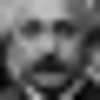

In [1618]:
EINSTEIN_POS = (73, 207) # this has been obtained from the image 
EINSTEIN = grayscale_image[EINSTEIN_POS[0]:EINSTEIN_POS[0]+WINDOW_SIZE, EINSTEIN_POS[1]:EINSTEIN_POS[1]+WINDOW_SIZE]
print(EINSTEIN.shape)
to_image(EINSTEIN).resize((100, 100))

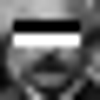

In [1619]:
left, top = 2,3
width, height = 10, 4

EINSTEIN_MASKED = EINSTEIN.copy()
EINSTEIN_MASKED[top:top+height//2, left:left+width] = 0
EINSTEIN_MASKED[top+height//2:top+height, left:left+width] = 1
to_image(EINSTEIN_MASKED).resize((100,100))

In [1620]:
f = Feature2v(x=left, y=top, width=width, height=height) # this will comply to 
# all faces images 

random.seed(0)
np.random.seed(0)
xs, ys = sample_normalized_data(50,50) # sample of images 
xs = np.array([integrate_image(x) for x in xs])
feature_values = np.array([f(x) for x in xs]) 

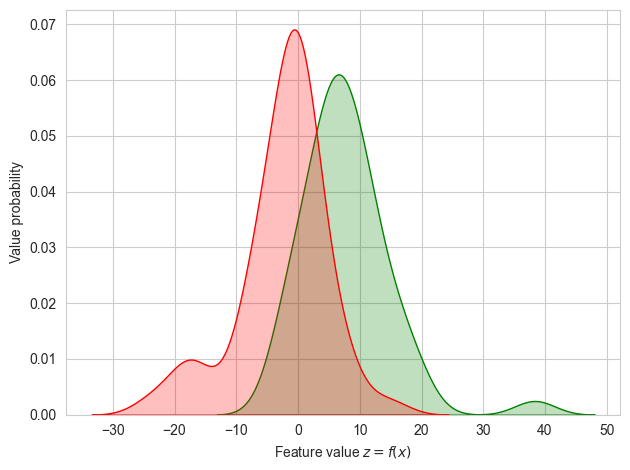

In [1621]:
# kernel denisty estimation 
sns.kdeplot(feature_values[ys > .5], color='g', fill=True) 

sns.kdeplot(feature_values[ys < .5], color='r', fill=True)

plt.xlabel('Feature value $z = f(x)$')
plt.ylabel('Value probability')
plt.tight_layout()
plt.show()

The two classes seems to not be seperated well. 

Lets measure the classification performance by means of precision and recall.


* Recall measures the proportion of actual positive cases that were correctly idendified by the model. 
$$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $$

**High recall value means less False Negatives.**


* Precision measures the proportion of positive identifications that were actually correct. 

$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $$

**High precision indicates that the model is precise in its positive predictions**



In [1622]:
average_precision = average_precision_score(ys, feature_values)
print(average_precision) # somehow high precision  

0.8716581474717895


In [1623]:
precision, recall, thresholds = precision_recall_curve(ys, feature_values)


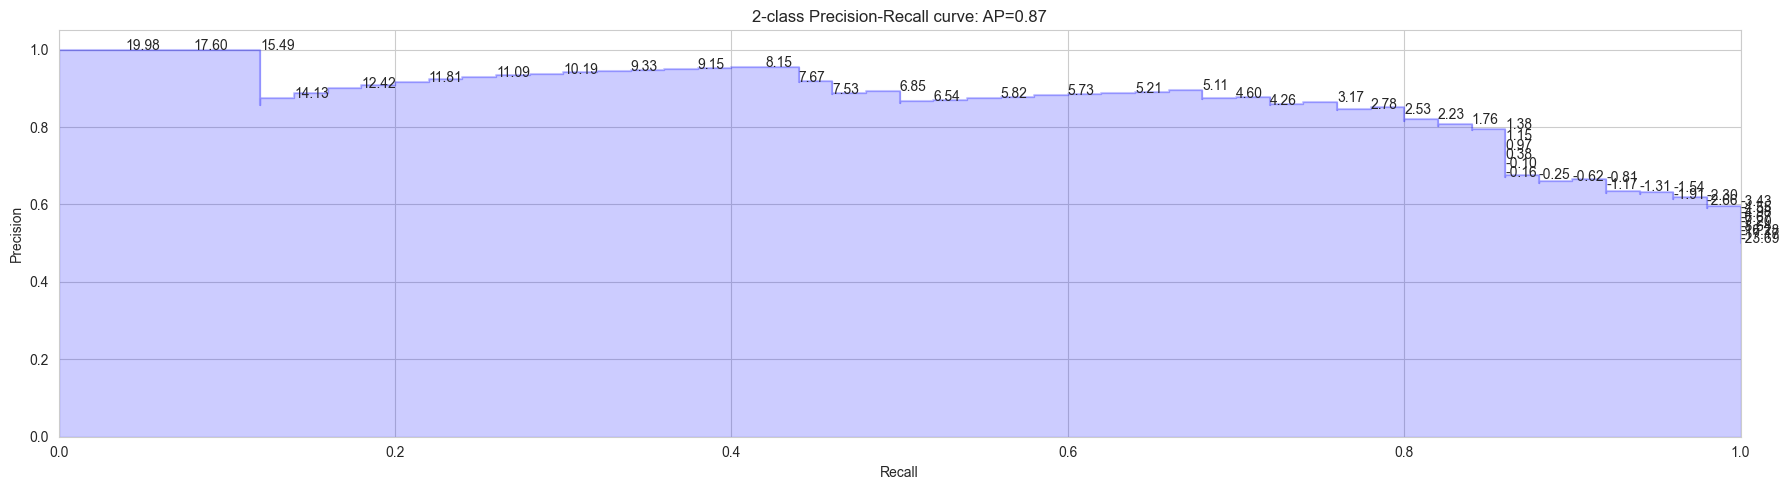

In [1624]:
plt.figure(figsize=(18,5))
plt.step(recall,precision, color = "b", alpha = 0.2, where = "post");
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b');

for i, (p, r, t) in enumerate(zip(precision, recall, thresholds)):
    if i % 2 == 0: # skip one 
        plt.annotate(f"{t:.2f}", xy=(r,p)) 

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.tight_layout()


In [1625]:
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
print(best_threshold) # the best threshold for the binary model 

1.3802251815795898


In [1626]:
print(sum(feature_values > 1.38), sum(feature_values < 1.38)) # make sense

54 46


It appears as we used this threshold, we would simultaneusly maximize precision and recall. let's look at the precision and recall values, as well as the confusion matrix for this threshold.

In [1627]:
PredictionStats = NamedTuple("PredictionStats", [("tn", int), ("fp", int), ('fn', int), ("tp",int)])

def prediction_stats(y_true, y_predicted): 
    c = confusion_matrix(y_true, y_predicted)
    tn, fp, fn, tp = c.ravel()  
    return c, PredictionStats(tn=tn, fp=fp, fn=fn, tp=tp)

In [1628]:
print(precision[best_threshold_index]) # precision at best threshold  
print(recall[best_threshold_index]) # recall value at best threshold 

0.7962962962962963
0.86


In [1629]:
theta = round(best_threshold,2)
c, s = prediction_stats(ys, feature_values >= theta)

print(f'Precision {s.tp/(s.tp+s.fp):.3}, recall {s.tp/(s.tp+s.fn):.3}.')

Precision 0.796, recall 0.86.


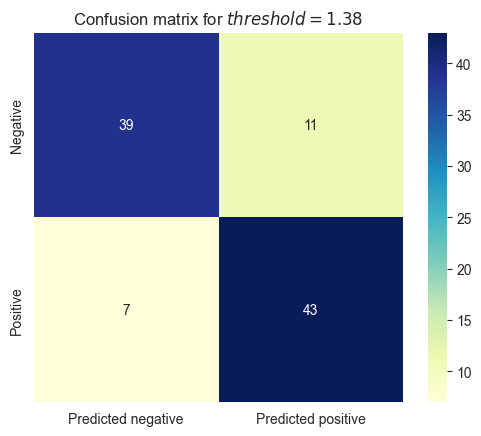

In [1630]:
sns.heatmap(c, cmap = "YlGnBu", annot=True, square=True, xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion matrix for $ threshold={theta}$');

###  Minimizer Algoritmically (Running Sums)

Given the running sums $S^+$ and $S^-$, as well as the total sums $T^+$ and $T^-$, the goal is to minimize the error $e$ such that

$$
\epsilon = \min\left( S^+ + \left(T^- - S^-\right) \quad,\quad S^- + \left(T^+ - S^+\right) \right).
$$

The first term, $S^+ + \left(T^- - S^-\right)$, is associated with the error of labelling all items below this threshold as "negative" (implying a detector polarity of $-1$), while labelling all above as "positive" and vice versa (i.e. a polarity of $+1$).



In [1631]:
p = np.argsort(feature_values)
feature_values = feature_values[p]
ys = ys[p]

In [1632]:
s_minuses, s_pluses = list(), list()
s_minus, s_plus = 0., 0.  
t_minus, t_plus = 0., 0. # the number of changes in s_minus or s_plus

for y in ys:
    if y == 0:
        s_minus += 1
        t_minus += 1
    else:
        s_plus += 1
        t_plus += 1
    s_minuses.append(s_minus)
    s_pluses.append(s_plus)

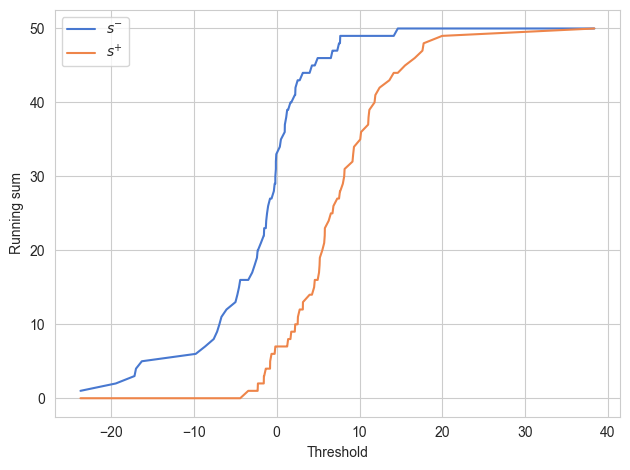

In [1633]:
plt.figure()
plt.plot(feature_values, s_minuses)
plt.plot(feature_values, s_pluses)
plt.legend(['$s^{-}$', '$s^{+}$'])
plt.xlabel('Threshold')
plt.ylabel('Running sum')
plt.tight_layout();

let us display the two errors  ($S^+ + \left(T^- - S^-\right)$)  \&  ($S^- + \left(T^+ - S^+\right)$)

In [1634]:
errors_1, errors_2 = list(), list()

min_e = float("inf") # starting off 
error_path_to_min = list()
min_indx = 0 
polarity = 0

for i, (s_m, s_p) in enumerate(zip(s_minuses, s_pluses)):
    error_1 = s_p + (t_minus - s_m) # the error measure of labeling all items below this threshold as negative 
    error_2 = s_m + (t_plus - s_p) # the error measure of labeling all items above this threshold as positive
    errors_1.append(error_1)
    errors_2.append(error_2)
    error_path_to_min.append(min_e)
    if error_1 < min_e:
        min_e = error_1
        polarity = -1 
        min_indx = i
    elif error_2 < min_e:
        min_e = error_2
        polarity = 1 
        min_indx = i


print(f'Minimal error: {min_e:.2} at index {min_indx} with threshold {feature_values[min_indx]:.2}. Classifier polarity is {polarity}.')

Minimal error: 1.7e+01 at index 52 with threshold 2.5. Classifier polarity is -1.


**The polairy indicates that all values below the threshold value are considered to be negative (non-faces).**

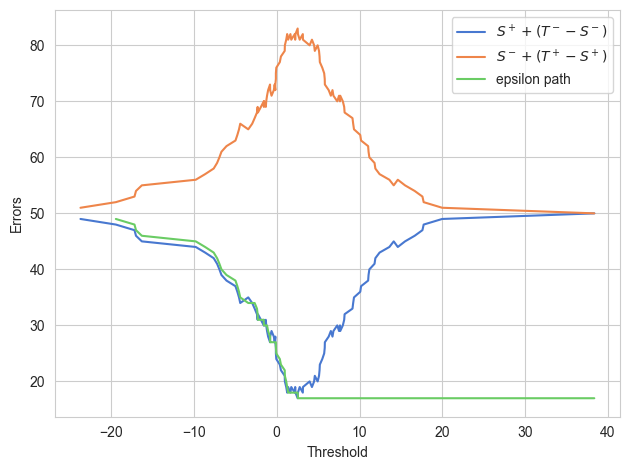

In [1635]:
plt.figure()
plt.plot(feature_values, errors_1)
plt.plot(feature_values, errors_2)
plt.plot(feature_values,error_path_to_min)
plt.legend(['$S^+ + (T^- - S^-)$', '$S^- + (T^+ - S^+)$', 'epsilon path'])
plt.xlabel('Threshold')
plt.ylabel('Errors')
plt.tight_layout();

Let us try again with this new threshold value

Precision 0.83, recall 0.8, false positive rate 0.16.


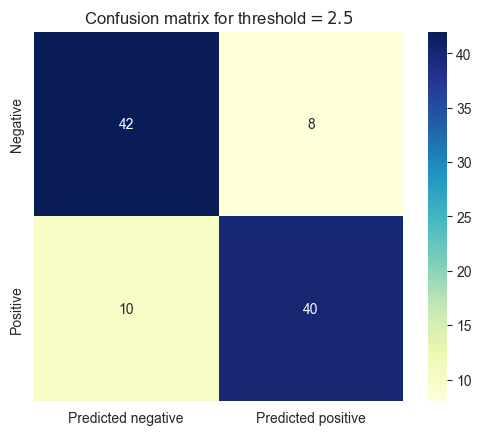

In [1636]:
theta = feature_values[min_indx]
c, s = prediction_stats(ys, feature_values >= theta)

sns.heatmap(c, cmap='YlGnBu', annot=True, square=True, 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion matrix for threshold$={theta:.2}$');

print(f'Precision {s.tp/(s.tp+s.fp):.2}, recall {s.tp/(s.tp+s.fn):.2}, false positive rate {s.fp/(s.fp+s.tn)}.')

**GOOD JOB**

## Adaptive Boosting 

In [1637]:
random.seed(1000)
np.random.seed(1000)
xs, ys = sample_normalized_data(1000, 700)